In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import subprocess

from scipy.stats import describe
from tqdm import tqdm

from astropy.io import fits

from lvmdrp.core import image
from lvmdrp.functions import imageMethod

import seaborn as sns

sns.set(context="talk", style="ticks", palette="husl", color_codes=True)

In [2]:
# data root path
LVM_DEV = os.path.expandvars("$LVMHUB")
LVM_ROOT = os.path.join(LVM_DEV, "data-califa")
LVM_DATA_LAB = os.path.join(LVM_ROOT, "lab")

In [3]:
frame_paths = sorted([os.path.join(root,file) for root, _, files in os.walk(LVM_ROOT) for file in files if file.endswith(".fits")])
# frame_paths = sorted([os.path.join(root,file) for root, _, files in os.walk(LVM_DATA_LAB) for file in files if file.endswith(".fits") or file.endswith(".fits.gz")])
print(f"frames matched in lab data path: {len(frame_paths)}")

frames matched in lab data path: 10


In [4]:
new_index = pd.MultiIndex.from_tuples(((pd.to_numeric(os.path.basename(os.path.dirname(file)),errors="ignore"),os.path.basename(file)) for file in frame_paths), names=("mjd", "filename"))
frames_header = pd.DataFrame(
    index=new_index,
    columns="OBJECT EXPTIME".split()
)
for idx, frame_path in tqdm(enumerate(frame_paths), total=len(frame_paths), desc="reading metadata from headers", ascii=True):
    try:
        hdr = fits.getheader(frame_path)
    except OSError:
        continue
    for column in frames_header.columns:
        frames_header.iloc[idx].loc[column] = hdr.get(column, np.nan)
frames_header = frames_header.mask(frames_header==-999).reset_index()

reading metadata from headers: 100%|##########| 10/10 [00:00<00:00, 245.18it/s]


In [5]:
frames_header

,mjd,filename,OBJECT,EXPTIME
0,data-califa,run305_00580.fits,cont_obj_1,4
1,data-califa,run305_00581.fits,cont_obj_1_field,16
2,data-califa,run305_00582.fits,arc_obj_1_HgHe,120
3,data-califa,run305_00583.fits,obj_1_p1_IC10,900
4,data-califa,run305_00584.fits,obj_1_p2_IC10,900
5,data-califa,run305_00585.fits,obj_1_p3_IC10,900
6,data-califa,run305_00586.fits,cont_obj_2,4
7,data-califa,run305_00587.fits,cont_obj_2_field,16
8,data-califa,run305_00588.fits,arc_obj_2_HgHe,120
9,data-califa,run305_00589.fits,obj_2_p1_NGC784,900


In [6]:
iframe = 0

print(frames_header.filename.values[iframe])
frame = fits.open(os.path.join(LVM_ROOT,frames_header.filename.values[iframe]))

ny, nx = frame[0].data.shape
data = frame[0].data

frame[0].header

run305_00580.fits


SIMPLE  =                    T / Created with PDL (http://pdl.perl.org)         
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 2048 / length of data axis 1                          
NAXIS2  =                 2056 / length of data axis 2                          
BUNIT   = 'Data Value'                                                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
LONGSTRN= 'OGIP 1.0'           / The HEASARC Long String Convention may be used.
COMMENT   This FITS file may contain long string keyword values that are        
COMMENT   continued over multiple keywords.  The HEASARC convention uses the &  
COMMENT   character at the e

In [7]:
frame_name = frames_header.filename.values[iframe].replace(".fits","")

# remover rayos cosmicos (no es necesario para datos del lab)
# imageMethod.LACosmic_drp(os.path.join(LVM_ROOT,f"{frame_name}.fits"), out_image=f"_data/{frame_name}.cosmic.fits", increase_radius=1, flim="1.3", parallel='1')

382 Fibers found


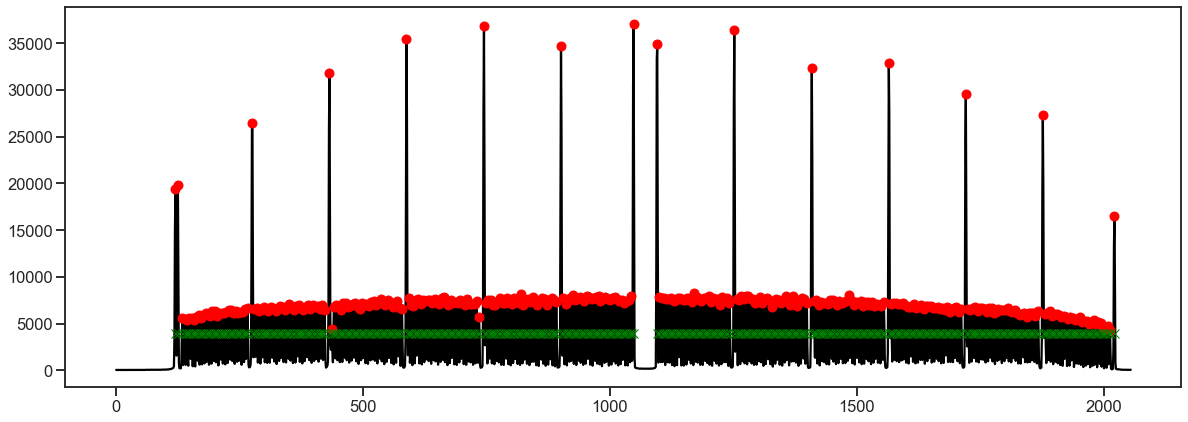

In [8]:
imageMethod.findPeaksAuto_drp(f"_data/{frame_name}.cosmic.fits", out_peaks_file=f"_data/{frame_name}.trace.peaks", nfibers=382)

In [10]:
# imageMethod.tracePeaks_drp(f"_data/{frame_name}.cosmic.fits", peaks_file=f"_data/{frame_name}.trace.peaks", trace_out=f"_data/{frame_name}.trc.fits", steps=30, method="gauss", threshold_peak=50, poly_disp=5, coadd=30, verbose=1)

Filename: _data/run305_00580.trc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (2048, 382)   float32   
  1  BADPIX        1 ImageHDU         8   (2048, 382)   uint8   


/home/mejia/.local/tmp/ipykernel_79979/3541498171.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(cosmic[0].data), origin="lower")
/home/mejia/.local/tmp/ipykernel_79979/3541498171.py:6: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(cosmic[0].data), origin="lower")


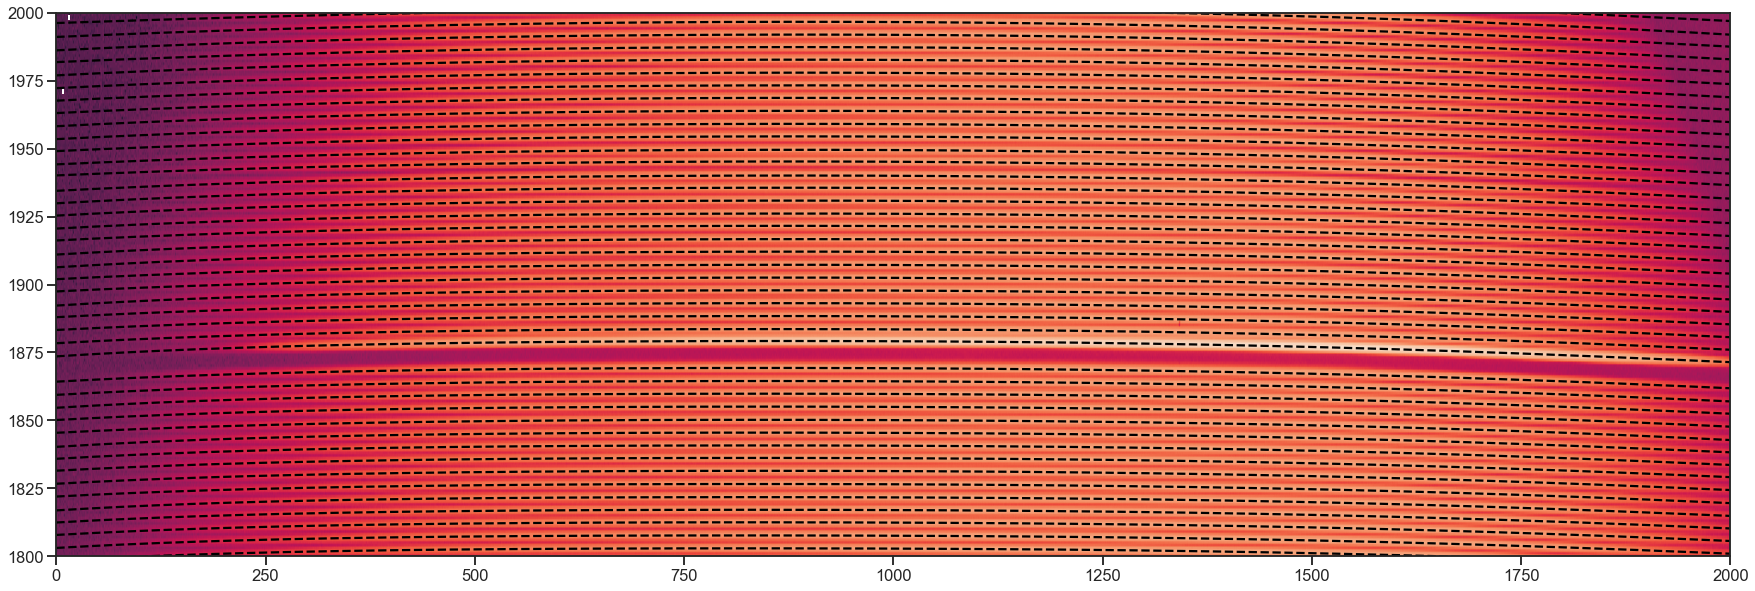

In [11]:
# cosmic = fits.open(f"_data/{frame_name}.cosmic.fits")
# trace = fits.open(f"_data/{frame_name}.trc.fits")
# trace.info()

# plt.figure(figsize=(30,10))
# plt.imshow(np.log10(cosmic[0].data), origin="lower")
# plt.gca().set_aspect("auto")
# plt.xlim(0,2000)
# plt.ylim(1800,2000)

# # plt.figure(figsize=(20,))
# xx = np.arange(0, cosmic[0].data.shape[1], 1)
# for iy in range(trace[0].data.shape[0]):
#     yy = trace[0].data[iy,:]
#     plt.plot(xx, yy, "--", color="k")

In [12]:
# remove luz directa (stray light)
# Py3D image subtractStraylight tjunk.fits tjunk.trc.fits  tjunk.back.fits tjunk.stray.fits aperture=40 poly_cross=2 smooth_gauss=30
# imageMethod.subtractStraylight_drp(f"_data/{frame_name}.cosmic.fits", f"_data/{frame_name}.trc.fits", f"_data/{frame_name}.back.fits", f"_data/{frame_name}.stray.fits", aperture=40, poly_cross=2, smooth_gauss=30)

In [13]:
# from pyds9 import *

# d = DS9()
# d.set(f"file _data/{frame_name}.back.fits")

In [14]:

# traza el ancho a lo largo de cross-dispersion
# Py3D image traceFWHM tjunk.stray.fits tjunk.trc.fits tjunk.fwhm.fits blocks=32 steps=30 coadd=20 threshold_flux=50.0 poly_disp=5 clip=1.5,4.0
# imageMethod.traceFWHM_drp(f"_data/{frame_name}.stray.fits", f"_data/{frame_name}.trc.fits", f"_data/{frame_name}.fwhm.fits", blocks=32, steps=30, coadd=20, threshold_flux=50.0, poly_disp=5, clip="1.5,4.0")

In [15]:
# d.set(f"file _data/{frame_name}.fwhm.fits")

In [16]:
# usar stray y fwhm frames para proyectar cualquier espectro en la CCD.
# buscar codigo para hacer disp_cor (identificacion de las lineas)

In [8]:
from lvmdrp.functions import rssMethod


# includePosTab
rssMethod.includePosTab_drp(f"_data/{frame_name}.trc.fits", os.path.join(LVM_ROOT,"configs","ppak_382_pt.txt"))

In [18]:
trace_rss = fits.open(f"_data/{frame_name}.trc.fits", memmap=False)

In [19]:
# extraccion (por traza)
# imageMethod.extractSpec_drp(f"_data/{frame_name}.stray.fits", f"_data/{frame_name}.trc.fits", f"_data/{frame_name}.aper.fits", method="aperture", aperture="5")
# extraccion (usando el FWHM)
# imageMethod.extractSpec_drp(f"_data/{frame_name}.stray.fits", f"_data/{frame_name}.trc.fits", f"_data/{frame_name}.ms.fits", method="optimal", fwhm=f"_data/{frame_name}.fwhm.fits", parallel=5)

In [20]:
from pyds9 import *

d = DS9()

In [21]:
aper = image.loadImage(f"_data/{frame_name}.aper.fits")
fwhm = image.loadImage(f"_data/{frame_name}.ms.fits")

fwhm_aper = fwhm - aper
d.set_np2arr(fwhm_aper._data)
# d.set(f"file _data/{frame_name}.ms.fits")

1

In [9]:
# extraer arco y 3 apuntados (remover stray light en objetos)
# extraccion del arco
arc_name = "run305_00582"
# imageMethod.extractSpec_drp(os.path.join(LVM_ROOT, f"{arc_name}.fits"), f"_data/{frame_name}.trc.fits", f"_data/{arc_name}.ms.fits", method="optimal", fwhm=f"_data/{frame_name}.fwhm.fits", parallel="5")

In [10]:
# d.set(f"file _data/{arc_name}.ms.fits")

In [11]:
object_name = "run305_00583"

# imageMethod.LACosmic_drp(os.path.join(LVM_ROOT,f"{object_name}.fits"), out_image=f"_data/{object_name}.cosmic.fits", increase_radius=1, flim="1.3", parallel='5')
# imageMethod.subtractStraylight_drp(f"_data/{object_name}.cosmic.fits", f"_data/{frame_name}.trc.fits", f"_data/{object_name}.back.fits", f"_data/{object_name}.stray.fits", aperture=40, poly_cross=2, smooth_gauss=30)
# imageMethod.extractSpec_drp(f"_data/{object_name}.stray.fits", f"_data/{frame_name}.trc.fits", f"_data/{object_name}.ms.fits", method="optimal", fwhm=f"_data/{frame_name}.fwhm.fits", parallel="5")

In [26]:
# d.set(f"file _data/{object_name}.ms.fits")

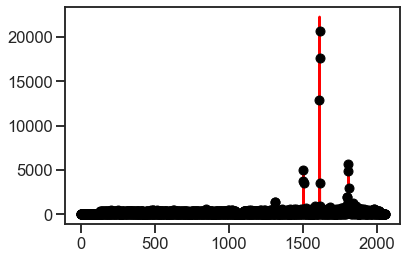

/home/mejia/.local/bin/miniconda3/envs/lvmdrp/lib/python3.8/site-packages/past/utils/__init__.py:95: RuntimeWarning: divide by zero encountered in true_divide
  return a / b


In [27]:
# proyectar espectro de entrada en la respuesta del instrumento usando la traza y el FWHM
imageMethod.testres_drp(f"_data/{object_name}.stray.fits", f"_data/{frame_name}.trc.fits", f"_data/{frame_name}.fwhm.fits", f"_data/{object_name}.ms.fits")

In [28]:
subprocess.run(f"ds9 _data/{object_name}.stray.fits ".split())

CompletedProcess(args=['ds9', '_data/run305_00583.stray.fits'], returncode=0)

In [29]:
# solucion de longitud de onda
# Py3D rss detWaveSolution arc.ms.fits arc ref_lines_ARC_V500.txt aperture=12 poly_fwhm=-7,-3 poly_dispersion=-7 rel_flux_limits=0.2,2 flux_min=100.0
# este paso deberia hacerse en simultaneo con el trazado de la FWHM (espacial), solucion simultanea en espacio y wavelength es el spectroperfectionism
# *.res.fits es la LSF
# *.disp.fits es el muestreo en wavelength
rssMethod.detWaveSolution_drp(
    f"_data/{arc_name}.ms.fits", arc_name,
    os.path.join(LVM_ROOT,"configs",f"ref_lines_ARC_HgHe_V500.txt"),
    aperture="12", poly_fwhm="-7,-3", poly_dispersion="-7", rel_flux_limits="0.2,2", flux_min="100.0", verbose="1"
)


subprocess.run(f"ds9 {arc_name}.disp.fits {arc_name}.res.fits".split())

Start measuring arc lines...


/home/mejia/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 9999.
  warnings.warn(errors[info][0], RuntimeWarning)


/disk-a/mejia/Research/UNAM/lvm-drp/lvmdrp/python/lvmdrp/core/fit_profile.py:550: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self._coeff=numpy.linalg.lstsq(eigen_poly, y)[0]


In [34]:
# a#adir solucion a los RSS
rssMethod.createPixTable_drp(
    f"_data/{arc_name}.ms.fits",
    f"_data/{arc_name}.rss.fits",
    f"{arc_name}.disp.fits", arc_fwhm=f"{arc_name}.res.fits", cropping=''
)

In [36]:
# Py3D rss resampleWave junk.sol.fits junk.disp_cor.fits start_wave=3745 end_wave=7600 disp_pix=2.0 err_sim=0
# crea *.disp_cor con datos remuestreados en longitud de onda
rssMethod.resampleWave_drp(
    f"_data/{arc_name}.rss.fits", f"_data/{arc_name}.disp_cor.fits",
    start_wave="3745", end_wave="7600", disp_pix="2.0", err_sim="0"
)

TypeError: __init__() missing 1 required positional argument: 'args'

In [37]:
subprocess.run(f"ds9 _data/{arc_name}.rss.fits _data/{arc_name}.disp_cor.fits".split())

CompletedProcess(args=['ds9', '_data/run305_00582.rss.fits', '_data/run305_00582.disp_cor.fits'], returncode=0)

In [38]:
# a#adir informacion de solucion en longitud de onda al continuo
rssMethod.createPixTable_drp(
    f"_data/{frame_name}.ms.fits",
    f"_data/{frame_name}.rss.fits",
    f"{arc_name}.disp.fits", arc_fwhm=f"{arc_name}.res.fits", cropping=''
)
# a#adir informacion de solucion en longitud de onda al objeto
rssMethod.createPixTable_drp(
    f"_data/{object_name}.ms.fits",
    f"_data/{object_name}.rss.fits",
    f"{arc_name}.disp.fits", arc_fwhm=f"{arc_name}.res.fits", cropping=''
)

In [40]:
# remuestrear continuo y objeto
rssMethod.resampleWave_drp(
    f"_data/{frame_name}.rss.fits", f"_data/{frame_name}.disp_cor.fits",
    start_wave="3745", end_wave="7600", disp_pix="2.0", err_sim="0"
)
rssMethod.resampleWave_drp(
    f"_data/{object_name}.rss.fits", f"_data/{object_name}.disp_cor.fits",
    start_wave="3745", end_wave="7600", disp_pix="2.0", err_sim="0"
)

subprocess.run(f"ds9 _data/{frame_name}.disp_cor.fits _data/{object_name}.disp_cor.fits".split())

In [ ]:
# crear fiberflat
rssMethod.createFiberFlat_drp(f"_data/{frame_name}.disp_cor.fits", f"_data/fiberflat.fits",
    clip="0.3,1.5", smooth_poly="0", valid="40,200"
)

# subprocess.run(f"ds9 _data/fiberflat.fits".split())

In [59]:
# aplicar correccion por flat
rssMethod.correctFiberFlat_drp(f"_data/{frame_name}.disp_cor.fits", f"_data/{frame_name}.fc.fits", f"_data/fiberflat.fits", clip="0.2")

rssMethod.correctFiberFlat_drp(f"_data/{object_name}.disp_cor.fits", f"_data/{object_name}.fc.fits", f"_data/fiberflat.fits", clip="0.2")

# subprocess.run(f"ds9 _data/{object_name}.fc.fits".split())

In [66]:
rssMethod.includePosTab_drp(f"_data/{frame_name}.fc.fits", os.path.join(LVM_ROOT,"configs","ppak_382_pt.txt"))
rssMethod.includePosTab_drp(f"_data/{object_name}.fc.fits", os.path.join(LVM_ROOT,"configs","ppak_382_pt.txt"))

In [ ]:
# mejor estimacion del cielo ================
# leer tabla de posiciones
# identificamos cielo
# interpolar cielo en el eje de crosdispersion para toda longitud de onda en la posicion de todas las fibras distintas del cielo
# el resultado debe ser un espectro de cielo por cada fibra != cielo
# hacer esto sobre el ms

In [12]:
# separar fibras de cielo, calibracion y objeto
rssMethod.splitFibers_drp(f"_data/{frame_name}.fc.fits",
    f"_data/{frame_name}.obj.fits,_data/{frame_name}.sky.fits,_data/{frame_name}.cal.fits",
    "OBJ,SKY,CAL"
)
rssMethod.splitFibers_drp(f"_data/{object_name}.fc.fits",
    f"_data/{object_name}.obj.fits,_data/{object_name}.sky.fits,_data/{object_name}.cal.fits",
    "OBJ,SKY,CAL"
)

# subprocess.run(f"ds9 _data/{object_name}.obj.fits".split())

In [21]:
# extraccion del cielo
rssMethod.constructSkySpec_drp(f"_data/{object_name}.sky.fits", f"_data/{object_name}.sky_spec.fits", clip_sigma="1.0")
rssMethod.subtractSkySpec_drp(f"_data/{object_name}.obj.fits", f"_data/{object_name}.sobj.fits", f"_data/{object_name}.sky_spec.fits")

# subprocess.run(f"ds9 _data/{object_name}.sky_spec.fits".split())
# subprocess.run(f"ds9 _data/{object_name}.obj.fits _data/{object_name}.sobj.fits".split())